Project description from DataCamp

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

To complete this project, you should be comfortable working with pandas DataFrames and with using the pandas plot method. You should also have some understanding of hypothesis testing and bootstrap analysis.

Problem Statement

We are testing whether moving the first gate in the mobile game Cookie Cats from level 30 to level 40 affects player retention and total game rounds played.

Objective

Analyze player retention rates and total game rounds played between two versions of the game (gate_30 and gate_40) and determine whether the difference is statistically significant.



Step1: Load data and explore data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data
data = pd.read_csv('C:/Users/xy200/OneDrive/Desktop/CV/cookie_cats.csv/cookie_cats.csv')

# Display the first few rows
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Step2: Exploratory Data Analysis

Perform exploratory data analysis to understand the distribution of key metrics such as sum_gamerounds, retention_1, and retention_7.

In [7]:
# Summary statistics:  the number of observations, the mean, the standard deviation, and specific percentiles that give us an understanding of the spread of the data.
summary_stats = data["sum_gamerounds"].describe(percentiles=[.01, .05, .10, .20, .50, .80, .90, .95])
print(summary_stats)

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
1%           0.000000
5%           1.000000
10%          1.000000
20%          3.000000
50%         16.000000
80%         67.000000
90%        134.000000
95%        221.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64


see how game rounds are distributed across all users. For instance, the mean number of game rounds is around 52, while the standard deviation is 195, indicating significant variation in player engagement. We notice that most players have a low number of rounds (e.g., the 50th percentile is at 16 rounds), but there are extreme outliers (max of 49,854 rounds).

In [8]:
# Compare summary statistics for Gate 30 and Gate 40
ab_grouped_stats = data.groupby("version")["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])
print(ab_grouped_stats)

         count  median       mean         std    max
version                                             
gate_30  44700    17.0  52.456264  256.716423  49854
gate_40  45489    16.0  51.298776  103.294416   2640


 the average number of game rounds is very similar between the two versions, but Gate 30 has a significantly larger max value/extreme outliers.

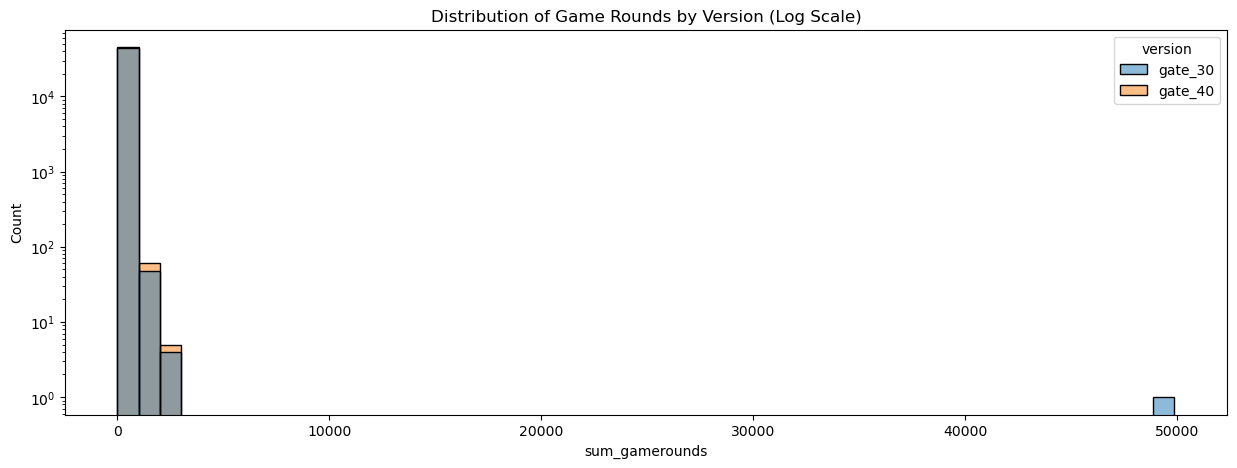

In [14]:
# Visualizing Distribution with Histograms and Boxplots
# Histogram with log scale
plt.figure(figsize=(15, 5))

# Plot histogram,use a logarithmic scale to make the data points more distinct.
sns.histplot(data=data, x="sum_gamerounds", hue="version", kde=False, log_scale=(False, True), bins=50)
plt.title("Distribution of Game Rounds by Version (Log Scale)")
plt.xlabel("sum_gamerounds")
plt.ylabel("Count")
plt.show()

1. The vast majority of users played very few game rounds
2. Both versions show similar distributions

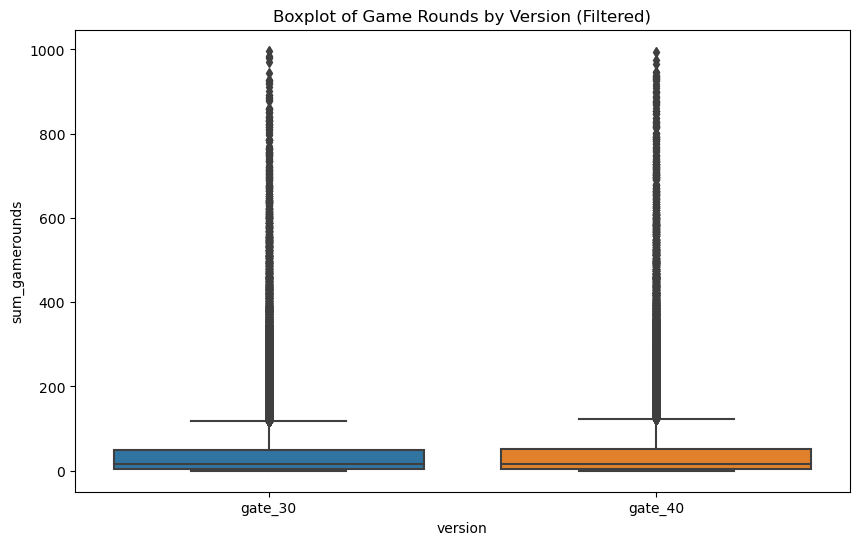

In [16]:
# Boxplot Without Extreme Outliers
# Removing extreme outliers for better visualization
# Assuming game rounds above a certain threshold are extreme outliers
threshold = 1000  # Adjust this value based on your dataset
filtered_ab = data[data["sum_gamerounds"] < threshold]

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="version", y="sum_gamerounds", data=filtered_ab)
plt.title("Boxplot of Game Rounds by Version (Filtered)")
plt.show()

1. After filtering out one outlier in gate_30,  both versions show a high concentration of users playing fewer rounds, with the IQR being similar. 
2. However, gate_30 displays more variance in user behavior, evidenced by the presence of numerous outliers reaching up to 1000 game rounds. Gate_40, in contrast, has fewer extreme outliers and a slightly tighter distribution. 

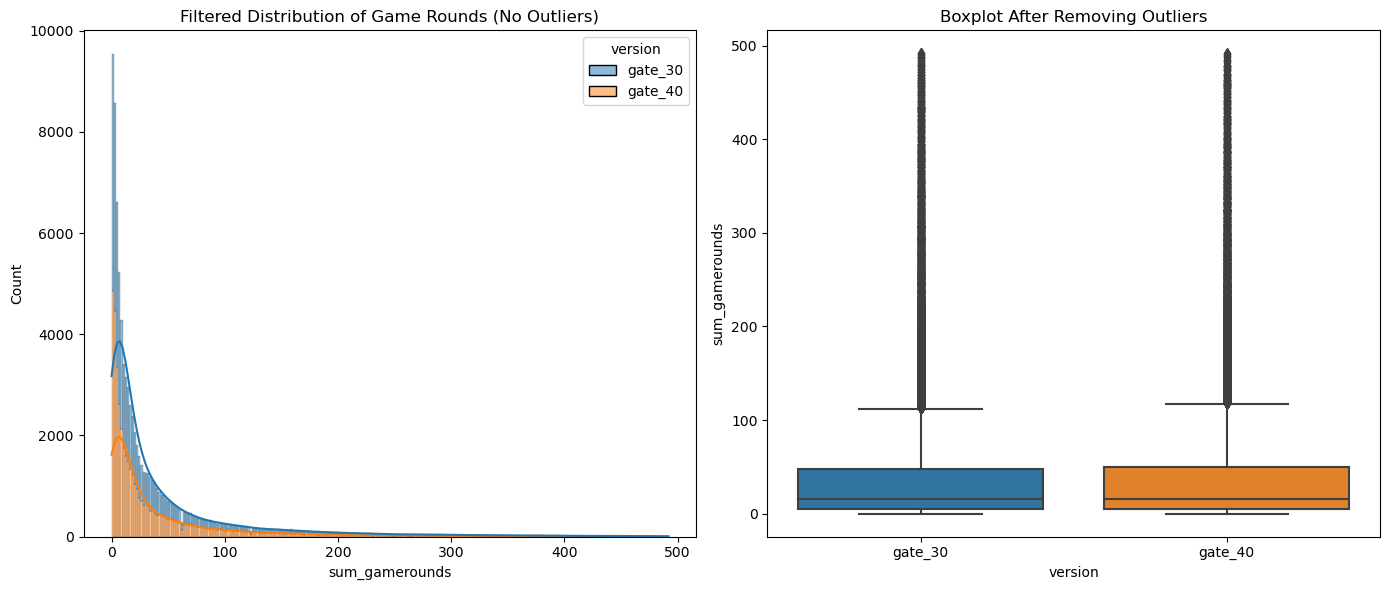

In [20]:
# Remove the top 1% of outliers
filtered_ab = data[data["sum_gamerounds"] < data["sum_gamerounds"].quantile(0.99)]

# Visualize the filtered data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(data=filtered_ab, x="sum_gamerounds", hue="version", multiple="stack", ax=axes[0], kde=True)
axes[0].set_title("Filtered Distribution of Game Rounds (No Outliers)")

sns.boxplot(x="version", y="sum_gamerounds", data=filtered_ab, ax=axes[1])
axes[1].set_title("Boxplot After Removing Outliers")

plt.tight_layout()
plt.show()

Ensure Correct Calculation of Retention Statistics: 
Calculate the count, median, mean, standard deviation, and maximum values for each group (by version and retention status). This allows a deeper understanding of the distribution of the game rounds across groups.

In [32]:
# Compute retention statistics grouped by version and retention status (True/False)
retention_summary = data.groupby(["version", "retention_1", "retention_7"]).agg(
    retention_1_count=("retention_1", "size"),
    retention_1_median=("sum_gamerounds", lambda x: round(x.median(), 4)),
    retention_1_mean=("sum_gamerounds", lambda x: round(x.mean(), 4)),
    retention_1_std=("sum_gamerounds", lambda x: round(x.std(), 4)),
    retention_1_max=("sum_gamerounds", "max"),
    retention_7_count=("retention_7", "size"),
    retention_7_median=("sum_gamerounds", lambda x: round(x.median(), 4)),
    retention_7_mean=("sum_gamerounds", lambda x: round(x.mean(), 4)),
    retention_7_std=("sum_gamerounds", lambda x: round(x.std(), 4)),
    retention_7_max=("sum_gamerounds", "max")
).reset_index()

print(retention_summary)

  version  retention_1  retention_7  retention_1_count  retention_1_median  \
0       A        False        False              22840                 6.0   
1       A        False         True               1826                43.0   
2       A         True        False              13358                33.0   
3       A         True         True               6676               127.0   
4       B        False        False              23597                 6.0   
5       B        False         True               1773                47.0   
6       B         True        False              13613                32.0   
7       B         True         True               6506               133.0   

   retention_1_mean  retention_1_std  retention_1_max  retention_7_count  \
0           11.8197          21.6426              981              22840   
1          100.4315        1168.6839            49854               1826   
2           49.6945          58.1254              918              13

Visualizing the Data for Retention: After aggregating the statistics, plot the results to visually interpret the retention behavior:

In [38]:
# Calculate retention rates
retention_stats = data.groupby("version")[["retention_1", "retention_7"]].mean()
print(retention_stats)

         retention_1  retention_7
version                          
A           0.448188     0.190201
B           0.442283     0.182000


Retention rates are slightly higher in Gate 30 than Gate 40, suggesting that users in Gate 30 may be more engaged and likely to return to the game. 

Step3: Define A/B Groups

In [24]:
# Define A/B groups
data['version'] = np.where(data['version'] == "gate_30", "A", "B")

# Display the updated dataframe
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


Step 4: Define Hypothesis

Null Hypothesis (H0): There is no significant difference in total game rounds played or retention rates between the two groups (A and B).
Alternative Hypothesis (H1): There is a significant difference in total game rounds played or retention rates between the two groups.

Step 5: A/B Test Function

Perform the A/B test based on normality, homogeneity of variance, and then apply the correct statistical test.
1. If the distribution is Normal and the variances are Homogeneous; apply the T-Test (parametric test)
2. If the distribution is Normal and the variances are not Homogeneous; apply Welch Test
3. If the distribution is not Normal; apply Mann Whitney U Test

In [73]:
# define A/B test function
def ab_test(dataframe, group, target):
    # group A and B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # clean，remove data > 95%
    groupA = groupA[groupA < groupA.quantile(0.95)]
    groupB = groupB[groupB < groupB.quantile(0.95)]
    
    # Normality test
    ntA = stats.shapiro(groupA)[1] < 0.05
    ntB = stats.shapiro(groupB)[1] < 0.05
    
    # variance test
    levene_test = stats.levene(groupA, groupB)[1] < 0.05
    
    # decide which test method is proper based on normality and homogeneity
    if not ntA and not ntB:
        if not levene_test:
            # both normally distributed and equal variances, use T-test
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
        else:
            # unequal variances，Welch t-test
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
    else:
        # not normally distributed，Mann-Whitney U test
        ttest = stats.mannwhitneyu(groupA, groupB, alternative='two-sided')[1]
    
    # return P value
    return ttest

# run A/B test
p_value = ab_test(dataframe=data, group='version', target='sum_gamerounds')

print(f"P-value for sum_gamerounds after removing outliers: {p_value:.5f}")

# check if p value < 0.05
if p_value < 0.05:
    print("Reject H0: A/B groups are significantly different!")
else:
    print("Fail to Reject H0: No significant difference between A/B groups.")

P-value for sum_gamerounds after removing outliers: 0.03381
Reject H0: A/B groups are significantly different!


C:\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Step6: Conclusion

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 

In this project, I analyzed the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

Retention is the primary metrics caz we need to keep player base to increase in-app purchase. 

The 1-day and 7-day average retention are higher when the gate is at level 30 than when it is at level 40.
So we will keep gate at level 30